### Import Pakages

In [1]:
import pandas as pd
import numpy as np
from pandas.io import gbq

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import sidetable as stb
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Basic Understanding Data

In [5]:
cs_data= """SELECT * FROM `bigquery-public-data.iowa_liquor_sales.sales` where (date >= '2018-01-01' AND date < '2019-12-31') 
and (county='Polk' or county='POLK')"""

df=gbq.read_gbq(cs_data, project_id="groovy-legacy-304712")
df.head()


Downloading: 100%|█████████████████████████████████████████████████████████| 868903/868903 [04:40<00:00, 3092.55rows/s]


,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-23349600012,2019-11-20,3656,Target Store T-1767 / Ankeny,2135 SE Delaware Ave,Ankeny,50021,POINT (-93.581201 41.708563),77,POLK,...,1258,Glenmorangie Taster Pack,6,100,14.99,22.49,6,134.94,0.60,0.15
1,INV-17832400001,2019-02-28,4136,Fareway Stores #983 / Grimes,351 Gateway Dr,Grimes,50111,None,77,POLK,...,77805,Saints N Sinners Apple Pie,12,750,8.00,12.00,24,288.00,18.00,4.75
2,INV-17157900005,2019-01-25,5131,Oasis,"1401, Buchanan St",Des Moines,50316,POINT (-93.599362 41.59878),77,POLK,...,67524,Kahlua Coffee,24,375,6.49,9.74,3,29.22,1.12,0.29
3,INV-17483200047,2019-02-12,3825,Shop N Save #2 / E 14th,1372 E 14th St,Des Moines,50316,POINT (-93.600499 41.604893),77,POLK,...,43034,Bacardi Gold,24,375,4.50,6.75,3,20.25,1.12,0.29
4,INV-19413800024,2019-05-17,5131,Oasis,"1401, Buchanan St",Des Moines,50316,POINT (-93.599362 41.59878),77,POLK,...,43034,Bacardi Gold,24,375,4.50,6.75,3,20.25,1.12,0.29


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868903 entries, 0 to 868902
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   invoice_and_item_number  868903 non-null  object        
 1   date                     868903 non-null  datetime64[ns]
 2   store_number             868903 non-null  object        
 3   store_name               868903 non-null  object        
 4   address                  868903 non-null  object        
 5   city                     868903 non-null  object        
 6   zip_code                 868903 non-null  object        
 7   store_location           761753 non-null  object        
 8   county_number            868903 non-null  object        
 9   county                   868903 non-null  object        
 10  category                 867990 non-null  object        
 11  category_name            867990 non-null  object        
 12  vendor_number   

### Data Cleaning
This Data Pre-Processing Includes below:
1. Dropping and Imputasi missing value
2. Checking Outlier
2. Checking for double transaction
4. Cleaning for store_location feature

In [6]:
#Checking for missing values
df.isna().sum()

invoice_and_item_number         0
date                            0
store_number                    0
store_name                      0
address                         0
city                            0
zip_code                        0
store_location             107150
county_number                   0
county                          0
category                      913
category_name                 913
vendor_number                   0
vendor_name                     0
item_number                     0
item_description                0
pack                            0
bottle_volume_ml                0
state_bottle_cost               0
state_bottle_retail             0
bottles_sold                    0
sale_dollars                    0
volume_sold_liters              0
volume_sold_gallons             0
dtype: int64

In [7]:
#dropping NA in store_location
df.dropna(subset=['store_location'], inplace=True)

In [8]:
#Imputation on 'category' and 'category_name'
#Since the attribut have object type, so I would impute it using mode
df['category'] = df.groupby('city')['category'].transform(lambda x:x.fillna(x.mode()[0]))
df['category_name'] = df.groupby('city')['category_name'].transform(lambda x:x.fillna(x.mode()[0]))

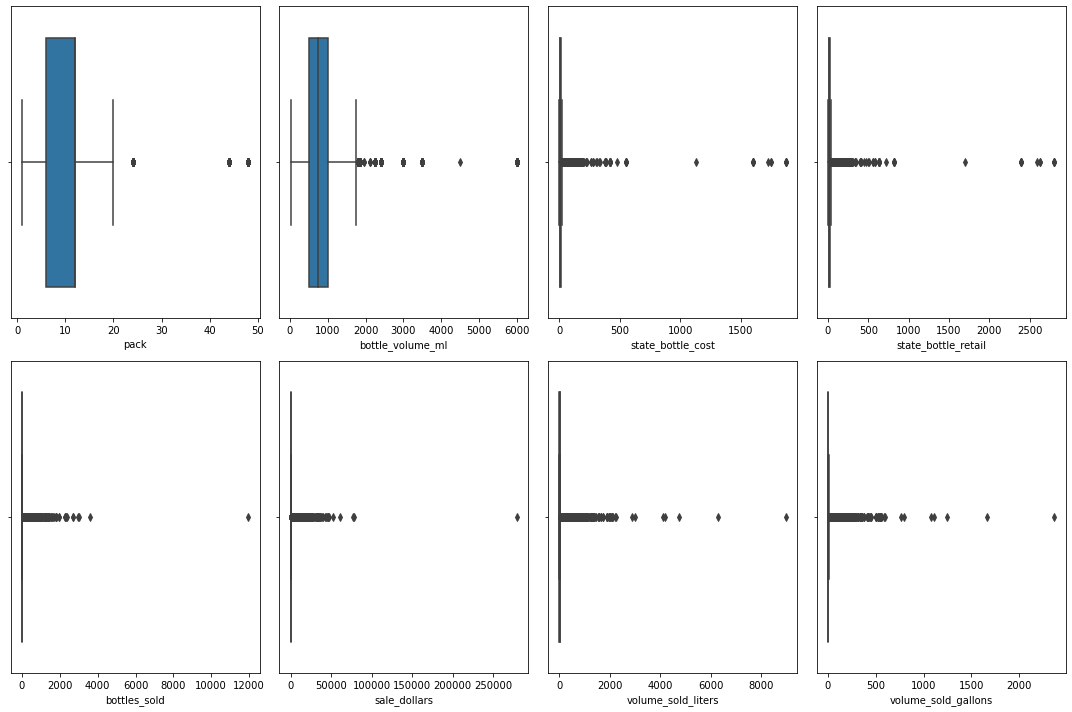

In [9]:
#Checking Outliers
df_desc=df.drop(columns='date')

#Separate between categoric and numeric cols
char_col = []
num_col = []
for col in df_desc.columns:
    if (df_desc[col].dtypes != 'object'):
        num_col.append(col)
    else:
        char_col.append(col)

#Figure out outlier through boxplot
plt.figure(figsize=(15,10))
for i, col in enumerate(num_col):
    plt.subplot(2,4,i+1)
    sns.boxplot(df[col])
    plt.tight_layout()

From the boxplot above, it show that for all columns contain with oulier

In [10]:
#Checking for double transaction
df.duplicated(subset=['invoice_and_item_number'], keep='first').sum()

#There no duplicate row from the data

0

In [11]:
#Removing 'POINT'
df['store_location'] = df['store_location'].apply(lambda x:x.replace('POINT (', ''))
df['store_location'] = df['store_location'].apply(lambda x:x.replace(')', ''))

In [12]:
#Splitting into 'Lat' and 'Long'
df[['Long','Lat']] = df.store_location.str.split(' ', expand=True)

### Descriptive Data

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pack,761753.0,12.841116,8.515408,1.00,6.00,12.00,12.00,48.00
bottle_volume_ml,761753.0,840.234695,515.740707,20.00,500.00,750.00,1000.00,6000.00
state_bottle_cost,761753.0,10.684650,11.412867,0.89,5.50,8.25,13.00,1871.20
state_bottle_retail,761753.0,16.029148,17.119482,1.34,8.25,12.38,19.50,2806.80
bottles_sold,761753.0,14.110859,43.447080,0.00,3.00,6.00,12.00,11952.00
sale_dollars,761753.0,191.254400,763.561928,0.00,40.44,90.00,171.00,279557.28
volume_sold_liters,761753.0,11.221658,42.790936,0.02,1.75,9.00,10.50,8964.00
volume_sold_gallons,761753.0,2.960567,11.304365,0.00,0.46,2.37,2.77,2368.03


In [13]:
df.describe(include='O').T

,count,unique,top,freq
invoice_and_item_number,761753,761753,INV-23704300023,1
store_number,761753,212,2633,43618
store_name,761753,222,Hy-Vee #3 / BDI / Des Moines,43618
address,761753,209,3221 SE 14th St,43618
city,761753,16,Des Moines,366330
zip_code,761753,29,50314,73812
store_location,761753,208,-93.596754 41.554101,43618
county_number,761753,1,77,761753
county,761753,2,POLK,696567
category,761753,54,1031100,125725


- From the describe table, there will be outliers in some of columns by looking from median and max in some columns
- The maximum number of bottles in case for the liquor ordered is 48 pack
- The median volume for each liquor bottle is 750 mililiters
- The median amount that Alcoholic Beverages Division Paid for each bottle is 8.25 usd
- The exspensive one of liquor bottle is 2806.80 usd, while the cheap one around 1.34 usd
- The maximum number of liquor ordered by store is 11952.00 bottles
- The maximum total cost of liquor is 279557.28
- Store that mostly order liquor is Hy-Vee #3 / BDI / Des Moines
- Mostly city where the store ordered is located in Des Moines
- Most category of the liquor liquor ordered is American Vodkas
- Most vendor name for brand of liquor ordered is DIAGEO AMERICAS

### Data Pre-Paration

#### Feature Engineering for EDA
1. Binning in feature bottle_volume_ml into four group:
   - small volume
   - medium volume
   - large volume 
   - very large volume

This binning based on (source: https://en.wikipedia.org/wiki/Alcohol_measurements)

2. Create delta_cost between 'state_bottle_cost' and 'state_bottle_retail' to know the revenue for each bottle

3. Converting date feature to year, week and day

4. Binning Bottles sold into low and high sold

In [13]:
#bottle_volume_ml
bin_volume = [20,285,475,947,6000]
label = ['small_vol','medium_vol','large_vol','very_large_vol']

df['bin_bottle_vol'] = pd.cut(df['bottle_volume_ml'], bins=bin_volume, labels=label)
df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,Long,Lat,bin_bottle_vol
0,INV-23349600012,2019-11-20,3656,Target Store T-1767 / Ankeny,2135 SE Delaware Ave,Ankeny,50021,-93.581201 41.708563,77,POLK,...,100,14.99,22.49,6,134.94,0.60,0.15,-93.581201,41.708563,small_vol
2,INV-17157900005,2019-01-25,5131,Oasis,"1401, Buchanan St",Des Moines,50316,-93.599362 41.59878,77,POLK,...,375,6.49,9.74,3,29.22,1.12,0.29,-93.599362,41.59878,medium_vol
3,INV-17483200047,2019-02-12,3825,Shop N Save #2 / E 14th,1372 E 14th St,Des Moines,50316,-93.600499 41.604893,77,POLK,...,375,4.50,6.75,3,20.25,1.12,0.29,-93.600499,41.604893,medium_vol
4,INV-19413800024,2019-05-17,5131,Oasis,"1401, Buchanan St",Des Moines,50316,-93.599362 41.59878,77,POLK,...,375,4.50,6.75,3,20.25,1.12,0.29,-93.599362,41.59878,medium_vol
5,INV-13178800013,2018-07-11,2238,Adventureland Inn,3200 Adventureland Dr,Altoona,50009,-93.49924000000001 41.658513,77,POLK,...,1000,2.33,3.50,120,420.00,120.00,31.70,-93.49924000000001,41.658513,very_large_vol


In [14]:
#delta_cost
df['delta_cost'] = df['state_bottle_retail'] - df['state_bottle_cost']

In [15]:
#Revenue
df['revenue'] = df['delta_cost'] * df['bottles_sold']

In [16]:
#convert date to year
df['date_year']=df['date'].dt.year
#Convert date to month and day
df['date_month'] = df['date'].dt.month
df['date_day'] = df['date'].dt.day_name()

In [54]:
df['bottles_sold'].describe()

count    761753.000000
mean         14.110859
std          43.447080
min           0.000000
25%           3.000000
50%           6.000000
75%          12.000000
max       11952.000000
Name: bottles_sold, dtype: float64

In [55]:
#bottle_sold_ml
bin_sold = [0,12,11952]
label = ['Low Sold','High Sold']

df['bin_bottle_sold'] = pd.cut(df['bottles_sold'], bins=bin_sold, labels=label)
df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,volume_sold_gallons,Long,Lat,bin_bottle_vol,delta_cost,revenue,date_year,date_month,date_day,bin_bottle_sold
0,INV-23349600012,2019-11-20,3656,Target Store T-1767 / Ankeny,2135 SE Delaware Ave,Ankeny,50021,-93.581201 41.708563,77,POLK,...,0.15,-93.581201,41.708563,small_vol,7.50,45.00,2019,11,Wednesday,Low Sold
2,INV-17157900005,2019-01-25,5131,Oasis,"1401, Buchanan St",Des Moines,50316,-93.599362 41.59878,77,POLK,...,0.29,-93.599362,41.59878,medium_vol,3.25,9.75,2019,1,Friday,Low Sold
3,INV-17483200047,2019-02-12,3825,Shop N Save #2 / E 14th,1372 E 14th St,Des Moines,50316,-93.600499 41.604893,77,POLK,...,0.29,-93.600499,41.604893,medium_vol,2.25,6.75,2019,2,Tuesday,Low Sold
4,INV-19413800024,2019-05-17,5131,Oasis,"1401, Buchanan St",Des Moines,50316,-93.599362 41.59878,77,POLK,...,0.29,-93.599362,41.59878,medium_vol,2.25,6.75,2019,5,Friday,Low Sold
5,INV-13178800013,2018-07-11,2238,Adventureland Inn,3200 Adventureland Dr,Altoona,50009,-93.49924000000001 41.658513,77,POLK,...,31.70,-93.49924000000001,41.658513,very_large_vol,1.17,140.40,2018,7,Wednesday,High Sold


### Exploratory Data Analyst

#### Univariate Analysis

In [14]:
df.stb.freq(['store_name']).head(10)

,store_name,count,percent,cumulative_count,cumulative_percent
0,Hy-Vee #3 / BDI / Des Moines,43618,5.726003,43618,5.726003
1,Central City 2,35560,4.668180,79178,10.394183
2,"Central City Liquor, Inc.",28883,3.791649,108061,14.185832
3,Hy-Vee #4 / WDM,22218,2.916693,130279,17.102525
4,Hy-Vee Wine and Spirits / WDM,19918,2.614758,150197,19.717284
5,Hy-Vee Food Store #2 / State Ankeny,19856,2.606619,170053,22.323903
6,Hy-Vee Food Store / Fleur / DSM,17979,2.360214,188032,24.684117
7,Hy-Vee Food and Drug / Grand / WDM,16617,2.181416,204649,26.865533
8,Hy-Vee Food Store / Altoona,15624,2.051059,220273,28.916591
9,Hy-Vee Food Store / Urbandale,15035,1.973737,235308,30.890328


In [15]:
df.stb.freq(['city']).head(10)

,city,count,percent,cumulative_count,cumulative_percent
0,Des Moines,366330,48.090392,366330,48.090392
1,West Des Moines,114852,15.077328,481182,63.167720
2,Ankeny,66218,8.692844,547400,71.860564
3,Urbandale,54035,7.093507,601435,78.954070
4,Altoona,35505,4.660960,636940,83.615030
5,Johnston,30547,4.010093,667487,87.625123
6,Grimes,26303,3.452957,693790,91.078079
7,Windsor Heights,19622,2.575901,713412,93.653980
8,Pleasant Hill,19622,2.575901,733034,96.229880
9,Clive,14191,1.862940,747225,98.092820


In [16]:
#Finding the most common zip code
df.stb.freq(['zip_code']).head(10)

,zip_code,count,percent,cumulative_count,cumulative_percent
0,50314,73812,9.689755,73812,9.689755
1,50317,71366,9.368654,145178,19.058409
2,50265,61007,8.008764,206185,27.067173
3,50320,58345,7.659307,264530,34.726480
4,50266,53845,7.068564,318375,41.795044
5,50322,50584,6.640473,368959,48.435516
6,50009,35505,4.660960,404464,53.096476
7,50021,34444,4.521676,438908,57.618152
8,50315,33415,4.386593,472323,62.004744
9,50023,31774,4.171168,504097,66.175913


In [17]:
df.stb.freq(['category_name']).head(10)

,category_name,count,percent,cumulative_count,cumulative_percent
0,American Vodkas,125725,16.504694,125725,16.504694
1,Canadian Whiskies,64415,8.456153,190140,24.960847
2,Straight Bourbon Whiskies,50883,6.679724,241023,31.640571
3,American Flavored Vodka,43470,5.706574,284493,37.347145
4,Whiskey Liqueur,36610,4.806020,321103,42.153165
5,Spiced Rum,32060,4.208713,353163,46.361878
6,Imported Vodkas,31271,4.105136,384434,50.467015
7,100% Agave Tequila,26689,3.503629,411123,53.970644
8,Blended Whiskies,25246,3.314198,436369,57.284842
9,American Brandies,23559,3.092735,459928,60.377576


In [18]:
df.stb.freq(['vendor_name']).head(10)

,vendor_name,count,percent,cumulative_count,cumulative_percent
0,DIAGEO AMERICAS,136573,17.928777,136573,17.928777
1,Jim Beam Brands,63056,8.277749,199629,26.206526
2,SAZERAC COMPANY INC,55221,7.249200,254850,33.455726
3,LUXCO INC,52379,6.876113,307229,40.331840
4,PERNOD RICARD USA,46375,6.087931,353604,46.419771
5,CONSTELLATION BRANDS INC,42804,5.619144,396408,52.038916
6,E & J Gallo Winery,36222,4.755085,432630,56.794000
7,SAZERAC NORTH AMERICA,31772,4.170906,464402,60.964906
8,Heaven Hill Brands,31723,4.164473,496125,65.129379
9,BACARDI USA INC,31606,4.149114,527731,69.278493


In [19]:
df.stb.freq(['bin_bottle_vol'])

,bin_bottle_vol,count,percent,cumulative_count,cumulative_percent
0,large_vol,397719,52.216777,397719,52.216777
1,very_large_vol,197050,25.870818,594769,78.087594
2,medium_vol,103455,13.582672,698224,91.670266
3,small_vol,63445,8.329734,761669,100.000000


In [20]:
df[['state_bottle_cost','state_bottle_retail']]

,state_bottle_cost,state_bottle_retail
0,14.99,22.49
2,6.49,9.74
3,4.50,6.75
4,4.50,6.75
5,2.33,3.50
...,...,...
868898,7.50,11.25
868899,11.00,16.50
868900,29.99,44.99
868901,12.45,18.68


### Multivariate Analysis

#### Category name and Bottle sold

In [18]:
#What kind of category_name that has high and low bottle sold ?
#Here are Top 10 category_name with high bottle sold
print('Top 10 category_name with high bottle sold')
print(df['bottles_sold'].groupby(df['category_name']).sum().sort_values(ascending=False).head(10))
print('--'*25)
#Here are Bottom 10 category_name
print('Bottom 10 category_name with low bottle sold')
df['bottles_sold'].groupby(df['category_name']).sum().sort_values(ascending=False).tail(10)


Top 10 category_name with high bottle sold
category_name
American Vodkas                2277404
Whiskey Liqueur                1005617
Canadian Whiskies               871661
Straight Bourbon Whiskies       522328
Spiced Rum                      472815
Imported Vodkas                 458647
American Flavored Vodka         448866
Mixto Tequila                   364957
American Cordials & Liqueur     322264
Imported Brandies               298191
Name: bottles_sold, dtype: int64
--------------------------------------------------
Bottom 10 category_name with low bottle sold


category_name
Iowa Distilleries                       1422
Iowa Distillery Whiskies                1080
American Sloe Gins                       598
American Cordials & Liqueurs             252
Imported Distilled Spirits Specialty     222
American Vodka                           198
Temporary &  Specialty Packages          179
Cocktails / RTD                           36
American Distilled Spirits Specialty      31
Imported Vodka                            18
Name: bottles_sold, dtype: int64

In [32]:
#what kind of category name that has high median amount/exspensive for store to pay?
#Here are Top 10 category_name with high amount 
print('Top 10 category_name with high amount')
print(df['state_bottle_retail'].groupby(df['category_name']).median().sort_values(ascending=False).head(10))
print('--'*25)
#Here are Bottom 10 category_name with low amount
print('Bottom 10 category_name with low bottle sold')
df['state_bottle_retail'].groupby(df['category_name']).median().sort_values(ascending=False).tail(10)


Top 10 category_name with high amount
category_name
Single Malt Scotch                      44.99
Imported Distilled Spirits Specialty    40.88
Iowa Distilleries                       34.13
Mezcal                                  28.50
Straight Rye Whiskies                   27.14
Cocktails / RTD                         26.06
Single Barrel Bourbon Whiskies          25.74
Scotch Whiskies                         25.65
Irish Whiskies                          23.99
Temporary &  Specialty Packages         23.39
Name: state_bottle_retail, dtype: float64
--------------------------------------------------
Bottom 10 category_name with low bottle sold


category_name
White Rum                       10.25
American Vodkas                 10.01
American Cordials & Liqueurs     9.75
Flavored Gin                     9.74
American Schnapps                9.71
American Brandies                8.31
American Sloe Gins               8.13
American Dry Gins                8.07
American Cordials & Liqueur      7.50
Triple Sec                       3.63
Name: state_bottle_retail, dtype: float64

#### Vendor name, Bottle sold, state_bottle_cost

In [23]:
#Which Vendor name that has high and low bottle sold?
print('Top 10 vendor_name with high bottle sold')
print(df['bottles_sold'].groupby(df['vendor_name']).sum().sort_values(ascending=False).head(10))
print('--'*25)
#Here are Bottom 10 vendor_name
print('Bottom 10 vendor_name with low bottle sold')
df['bottles_sold'].groupby(df['vendor_name']).sum().sort_values(ascending=False).tail(10)


Top 10 vendor_name with high bottle sold
vendor_name
DIAGEO AMERICAS             1697243
SAZERAC COMPANY  INC        1583711
LUXCO INC                    839399
Jim Beam Brands              705550
CONSTELLATION BRANDS INC     653724
PERNOD RICARD USA            636649
SAZERAC NORTH AMERICA        528819
FIFTH GENERATION INC         438376
E & J Gallo Winery           412290
McCormick Distilling Co.     391848
Name: bottles_sold, dtype: int64
--------------------------------------------------
Bottom 10 vendor_name with low bottle sold


vendor_name
Flemish Lion LLC                    6
Local Choice Inc                    6
AMERICAN SPIRITS EXCHANGE           6
One Eight Distilling LLC            6
US Stone Castle Imports LLC         6
FRANK LIN DISTILLERS PRO            6
Savage & Cooke / Santa Croce LLC    6
PARADISE DISTILLING COMPANY         4
Des Moines Imports                  4
Mast-Jaegermeister US, Inc          1
Name: bottles_sold, dtype: int64

In [24]:
#Which Vendor name that have exspensive cost and cheap cost?
print('Top 10 vendor_name with exspensive median cost')
print(df['state_bottle_cost'].groupby(df['vendor_name']).median().sort_values(ascending=False).head(10))
print('--'*25)
#Here are Bottom 10 vendor_name
print('Bottom 10 vendor_name with cheap median cost')
df['state_bottle_cost'].groupby(df['vendor_name']).median().sort_values(ascending=False).tail(10)

Top 10 vendor_name with exspensive median cost
vendor_name
Fetzer Vineyards                   69.96
BMC Imports                        65.00
PACIFIC EDGE WINE & SPIRITS        63.50
Richland Distilling Company LLC    60.00
AMERICAN SPIRITS EXCHANGE          54.67
CVI Brands                         49.00
BLAUM BROTHERS DISTILLING CO       41.00
GoAmericaGo Beverages LLC          39.17
IMPEX BEVERAGE INC                 36.00
Dorado, Pizzorni & Sons, LLC       35.60
Name: state_bottle_cost, dtype: float64
--------------------------------------------------
Bottom 10 vendor_name with cheap median cost


vendor_name
Swell Liquor LLC                 6.00
Mango Bottling                   6.00
Caribbean Distillers, LLC        5.84
Levecke Corporation              5.51
Southern Italy Imports           5.50
Prestige Wine & Spirits Group    5.00
LUXCO INC                        5.00
DEHNER DISTILLERY                5.00
Laird & Company                  3.50
McCormick Distilling Co.         3.31
Name: state_bottle_cost, dtype: float64

#### bin_bottle_vol & Bottle sold

In [35]:
#Which bottle volume that has high bottle sold?
df['bottles_sold'].groupby(df['bin_bottle_vol']).median().sort_values(ascending=False)

#For all bottle volume have same median bottle sold

bin_bottle_vol
very_large_vol    6
large_vol         6
medium_vol        6
small_vol         6
Name: bottles_sold, dtype: int64

In [38]:
#which bottle volume has exspensive amount that store should pay?
df['state_bottle_retail'].groupby(df['bin_bottle_vol']).median().sort_values(ascending=False)

bin_bottle_vol
very_large_vol    15.75
large_vol         13.59
medium_vol         7.50
small_vol          5.88
Name: state_bottle_retail, dtype: float64

### Visualization

#### Bottle Volume

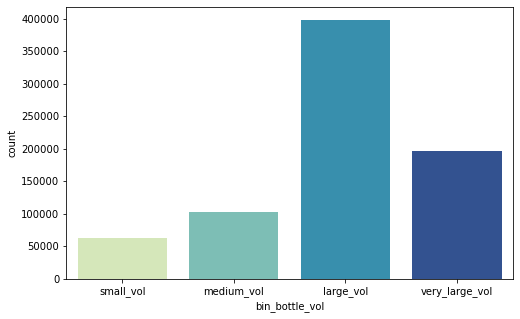

In [44]:
plt.figure(figsize=(8,5))
sns.countplot(df['bin_bottle_vol'], palette='YlGnBu')
plt.show()

In [23]:
df_vol = df['state_bottle_retail'].groupby(df['bin_bottle_vol']).median().sort_values(ascending=False)
df_vol.values

array([15.75, 13.59,  7.5 ,  5.88])

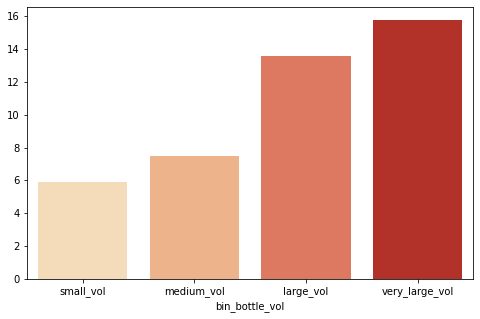

In [34]:
plt.figure(figsize=(8,5))
sns.barplot(x=df_vol.index, y=df_vol.values, palette='OrRd')
plt.show()

#### Store Name

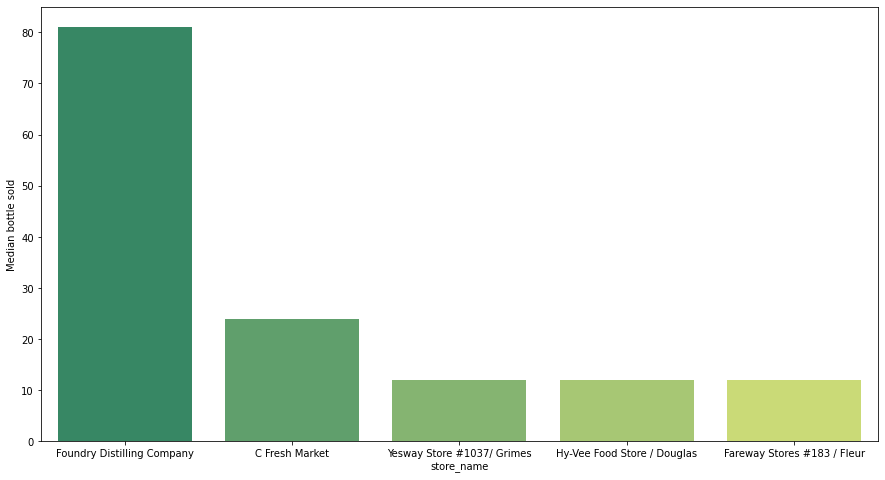

In [53]:
df_store = df['bottles_sold'].groupby(df['store_name']).median().sort_values(ascending=False)[0:5]
plt.figure(figsize=(15,8))
sns.barplot(x=df_store.index, y=df_store.values, palette='summer')
plt.ylabel('Median bottle sold')
plt.show()

In [54]:
df_store

store_name
Foundry Distilling Company     81.0
C Fresh Market                 24.0
Yesway Store #1037/ Grimes     12.0
Hy-Vee Food Store / Douglas    12.0
Fareway Stores #183 / Fleur    12.0
Name: bottles_sold, dtype: float64

#### Sales

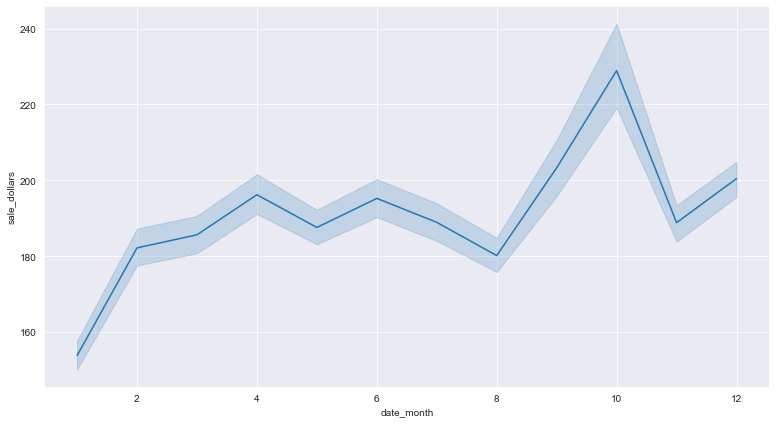

In [108]:
plt.figure(figsize=(13,7))
sns.set_style('darkgrid')
sns.lineplot(x = df['date_month'], y=df['sale_dollars'])
plt.show()

In [61]:
 df['sale_dollars'].groupby(df['date_month']).sum().sort_values(ascending=False)

date_month
10    1.510974e+07
12    1.445001e+07
5     1.326947e+07
8     1.238188e+07
6     1.231343e+07
11    1.212737e+07
9     1.189463e+07
7     1.188418e+07
4     1.173659e+07
3     1.131848e+07
2     1.010816e+07
1     9.094671e+06
Name: sale_dollars, dtype: float64

#### Volume Sold (Litters) & (Gallons)

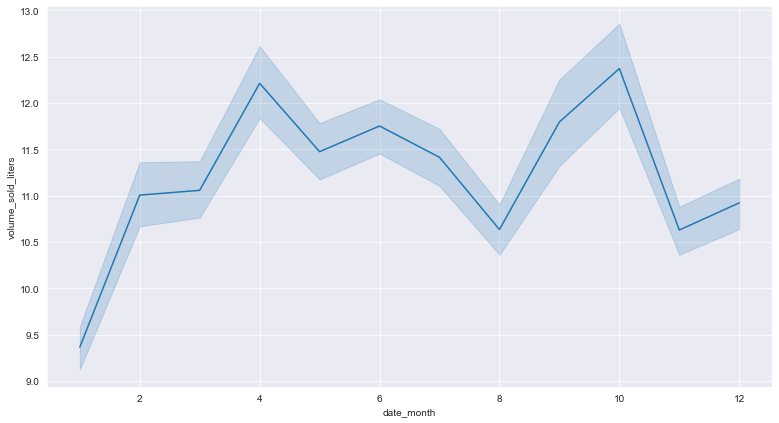

In [62]:
#volume_sold_liters
plt.figure(figsize=(13,7))
sns.set_style('darkgrid')
sns.lineplot(x = df['date_month'], y=df['volume_sold_liters'])
plt.show()

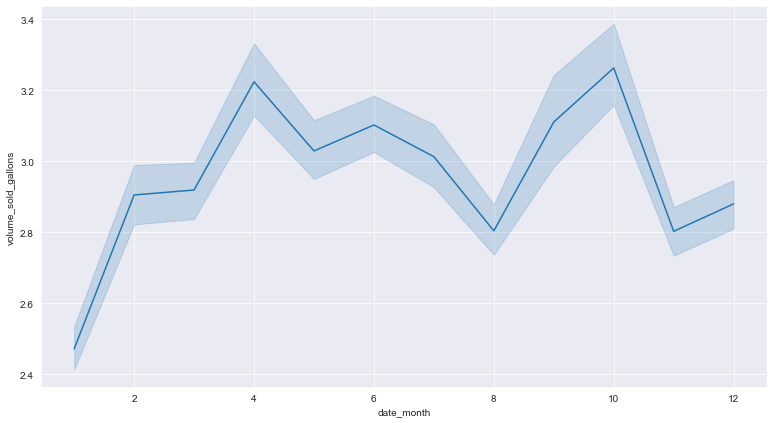

In [63]:
#volume_sold_gallons
plt.figure(figsize=(13,7))
sns.set_style('darkgrid')
sns.lineplot(x = df['date_month'], y=df['volume_sold_gallons'])
plt.show()

In [58]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [65]:
import folium 

#### sale_dollars Distribution Visualization

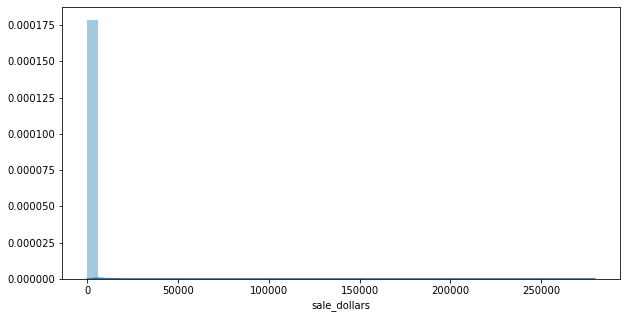

In [69]:
plt.figure(figsize = (10, 5))
sns.distplot(df['sale_dollars'])
plt.show()

#### Plot Total Sales for each year

In [18]:
#New dataframe to count total of sales 
df_2018 = df[df['date_year']==2018]
df_2019 = df[df['date_year']==2019]

In [22]:
#list to store month-sale-2018
month=[] 
month_order=[] 

for i in range(max(df_2018['date_month'])):
    month.append(i) 
    month_order.append(df[df['date_month']==i].sale_dollars.sum()) 
    
#list to store month-sale-2019
month19=[] 
month19_order=[] 

for i in range(max(df_2019['date_month'])): 
    month19.append(i) 
    month19_order.append(df[df['date_month']==i].sale_dollars.sum())

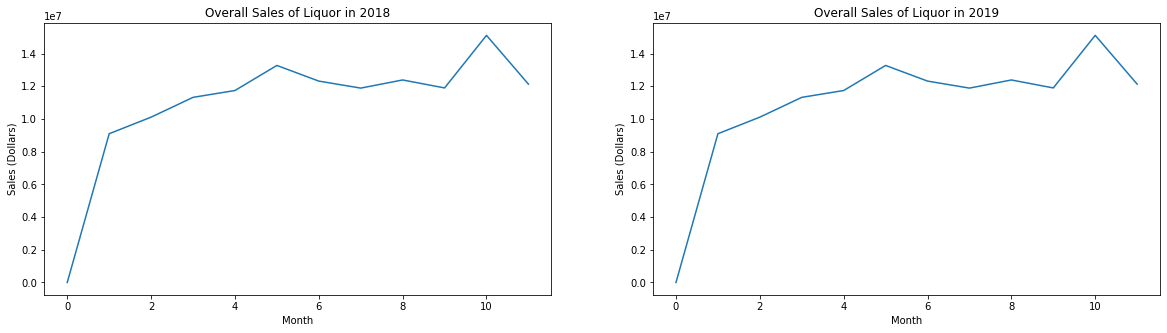

In [26]:
#subplots returns a Figure and an Axes object 
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5)) 

#manipulating the first Axes 
ax[0].plot(month,month_order) 
ax[0].set_xlabel('Month') 
ax[0].set_ylabel('Sales (Dollars)') 
ax[0].set_title('Overall Sales of Liquor in 2018') 

#manipulating the second Axes 
ax[1].plot(month19,month19_order) 
ax[1].set_xlabel('Month') 
ax[1].set_ylabel('Sales (Dollars)') 
ax[1].set_title('Overall Sales of Liquor in 2019') 

#save and display the plot 
# plt.savefig('matplotlib_plotting_11.png',dpi=300,bbox_inches='tight') 
plt.show();

- Its seem that Total Sales of liquor in both 2018 and 2019 have some pattern. **September** has the highest one of total sales

#### Overall Transactions by Month

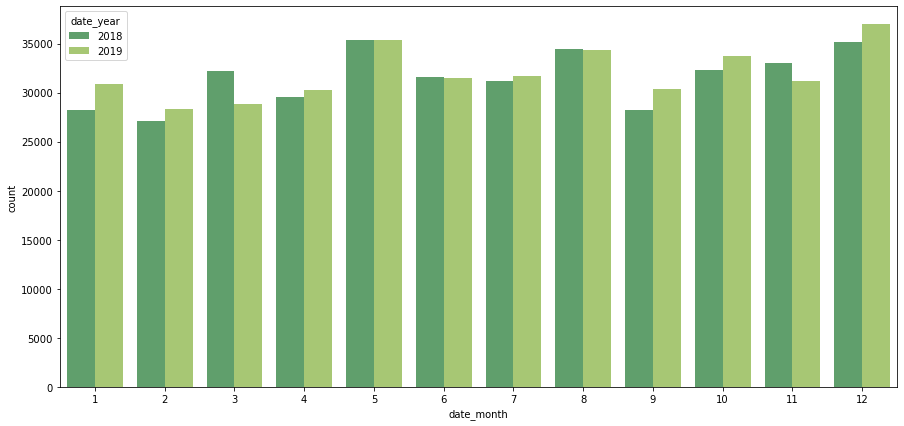

In [77]:
plt.figure(figsize=(15,7))
sns.countplot(x=df['date_month'], hue=df['date_year'], palette='summer')
plt.show()

In [33]:
byDay = df.groupby(['date_day','date_month']).count()
# byDay
bymonth_day = byDay['bottles_sold'].unstack()
bymonth_day

date_month,1,2,3,4,5,6,7,8,9,10,11,12
date_day,,,,,,,,,,,,
Friday,8039.0,5613.0,7142.0,6558.0,11545.0,9688.0,10810.0,11683.0,9176.0,9290.0,10766.0,15024.0
Monday,6654.0,7433.0,7883.0,10876.0,7206.0,11160.0,13149.0,10479.0,8592.0,11317.0,11753.0,15548.0
Saturday,NaN,NaN,NaN,711.0,NaN,466.0,NaN,NaN,NaN,NaN,1315.0,1152.0
Sunday,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,269.0,NaN,NaN,NaN
Thursday,24911.0,25533.0,28227.0,24877.0,29326.0,25173.0,20260.0,29773.0,23895.0,25385.0,22307.0,22616.0
Tuesday,14064.0,13165.0,13429.0,10988.0,11833.0,9074.0,11157.0,9386.0,10435.0,11070.0,9777.0,8341.0
Wednesday,5481.0,3745.0,4297.0,5813.0,10824.0,7515.0,7535.0,7413.0,6149.0,8943.0,8310.0,9412.0


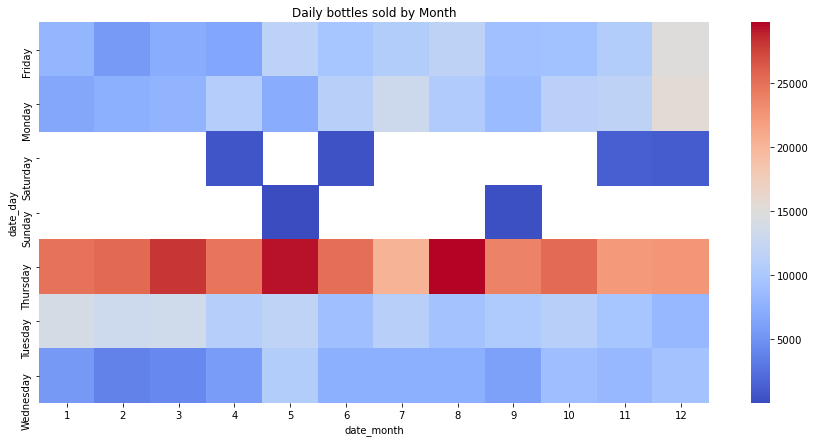

In [30]:
plt.figure(figsize = (15,7))
sns.heatmap(bymonth_day, cmap = 'coolwarm')
plt.title("Daily bottles sold by Month")
plt.show()

- From the heatmap above it shows that for all months in Saturday and Sunday, mostly there wasn't bottles sold
- In fact, Thursday have highest bottles sold for all over month especially in March, May and August

### `city`

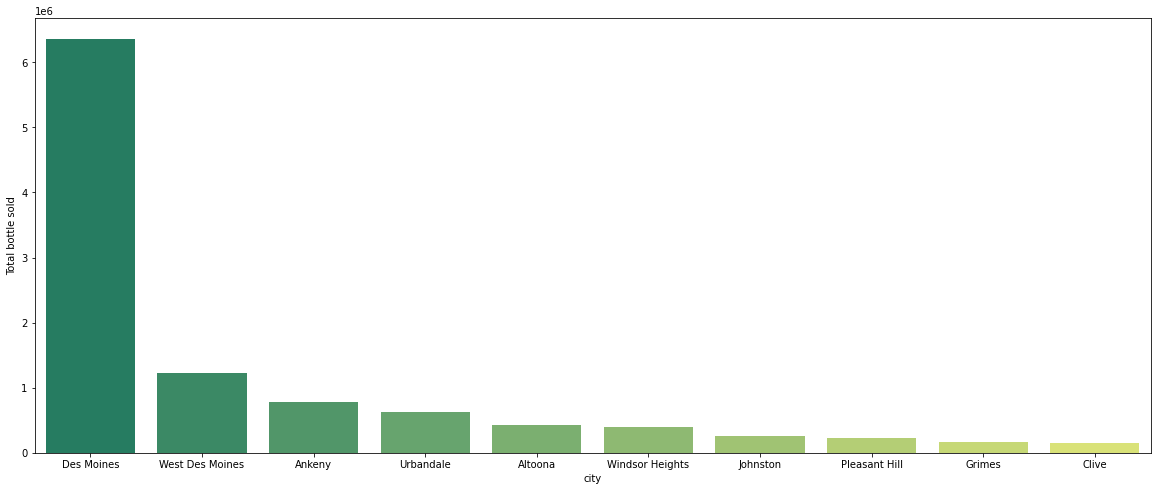

In [25]:
df_city = df['bottles_sold'].groupby(df['city']).sum().sort_values(ascending=False)[0:10]
plt.figure(figsize=(20,8))
sns.barplot(x=df_city.index, y=df_city.values, palette='summer')
plt.ylabel('Total bottle sold')
plt.show()

In [21]:
df_city

city
Des Moines         6363819
West Des Moines    1229391
Ankeny              786741
Urbandale           629225
Altoona             424923
Windsor Heights     392062
Johnston            256972
Pleasant Hill       231706
Grimes              170745
Clive               145818
Name: bottles_sold, dtype: int64

In [17]:
df.columns

Index(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number', 'vendor_name',
       'item_number', 'item_description', 'pack', 'bottle_volume_ml',
       'state_bottle_cost', 'state_bottle_retail', 'bottles_sold',
       'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons', 'Long',
       'Lat', 'bin_bottle_vol', 'delta_cost', 'revenue', 'date_year',
       'date_month', 'date_day'],
      dtype='object')

In [60]:
#
df_city1 = df[(df['city'] == 'Urbandale') | (df['city'] == 'Ankeny') | (df['city'] == 'Altoona') | (df['city'] == 'Windsor Heights')]

Since Urbandale, Ankeny, Altoona and Windsor Heights have high median of bottles sold, so in the next analysis I would focus among them to find potential city for opening new store. 
Bases on research that I have done, here are some information about each city:
1. Windsor Heights
   - Area: 3.7 km²
   - Population: 4,953 (2019)
2. Ankeny
   - Area: 77.96 km²
   - Population: 61,938 (2019)
3. Altoona
   - Population: 28.29 km²
   - Area: 18,458 (2019)
4. Urbandale
   - Area: 58.28 km²
   - Population: 43,441 (2019)
   
Next, i would know about the 'state bottle retail' to know the amount the store paid for each bottle of liquor ordered.

In [102]:
 df_city1['store_name'].value_counts()[0:5]

Hy-Vee Food Store #2 / State Ankeny    19856
Hy-Vee Food Store / Altoona            15624
Hy-Vee Food Store / Urbandale          15035
Urbandale Liquor                       11796
Sam's Club 6344 / Windsor Heights       7296
Name: store_name, dtype: int64

In [106]:
df_city_store = df_city1[(df_city1['store_name'] == 'Hy-Vee Food Store #2 / State Ankeny') | (df_city1['store_name'] == 'Hy-Vee Food Store / Altoona') | (df_city1['store_name'] == 'Hy-Vee Food Store / Urbandale') | (df_city1['store_name'] == 'Urbandale Liquor') | (df_city1['store_name'] == "Sam's Club 6344 / Windsor Heights")]

In [107]:
#This code aims to know median amount per store in given city
pd.crosstab(index=df_city_store['city'], columns=df_city_store['store_name'], values=df_city_store['state_bottle_retail'], aggfunc='median')

store_name,Hy-Vee Food Store #2 / State Ankeny,Hy-Vee Food Store / Altoona,Hy-Vee Food Store / Urbandale,Sam's Club 6344 / Windsor Heights,Urbandale Liquor
city,,,,,
Altoona,NaN,12.38,NaN,NaN,NaN
Ankeny,15.0,NaN,NaN,NaN,NaN
Urbandale,NaN,NaN,15.0,NaN,11.76
Windsor Heights,NaN,NaN,NaN,19.5,NaN


In [96]:
df_city1.columns

Index(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number', 'vendor_name',
       'item_number', 'item_description', 'pack', 'bottle_volume_ml',
       'state_bottle_cost', 'state_bottle_retail', 'bottles_sold',
       'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons', 'Long',
       'Lat', 'bin_bottle_vol', 'delta_cost', 'revenue', 'date_year',
       'date_month', 'date_day', 'bin_bottle_sold'],
      dtype='object')

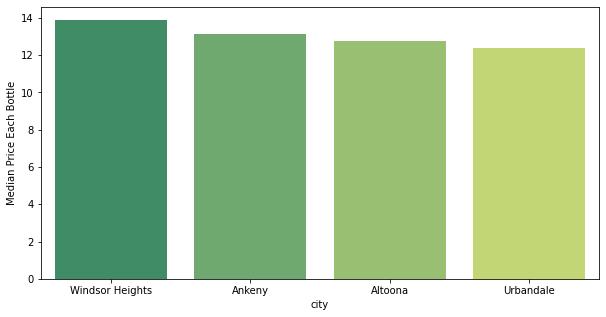

city
Windsor Heights    13.88
Ankeny             13.11
Altoona            12.74
Urbandale          12.38
Name: state_bottle_retail, dtype: float64


In [31]:
#This code aims to know median price for each bottle for every city
df_potensial = df_city1['state_bottle_retail'].groupby(df_city1['city']).median().sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=df_potensial.index, y=df_potensial.values, palette='summer')
plt.ylabel('Median Price Each Bottle')
plt.show()
print(df_potensial)

Since Windsor Heights  have high median price for each bottle with little population and area, so I dont recommend this city

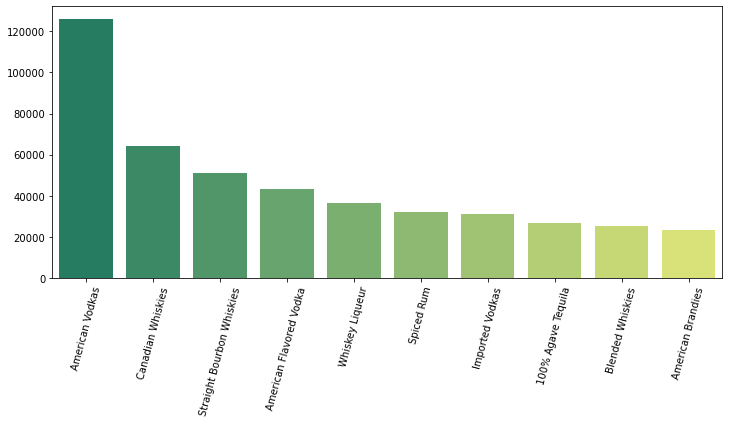

American Vodkas              125725
Canadian Whiskies             64415
Straight Bourbon Whiskies     50883
American Flavored Vodka       43470
Whiskey Liqueur               36610
Spiced Rum                    32060
Imported Vodkas               31271
100% Agave Tequila            26689
Blended Whiskies              25246
American Brandies             23559
Name: category_name, dtype: int64


In [48]:
#This code aims to know Top 10 category of liquor for every city
df_PotCat= df['category_name'].value_counts()[0:10]
plt.figure(figsize=(12,5))
sns.barplot(x=df_PotCat.index, y=df_PotCat.values, palette='summer')
plt.xticks(rotation=75)
plt.show()
print(df_PotCat)

In [88]:
# Top 10 vendor_name of the company in 4 country for the brand of liquor ordered
df_city.stb.freq(['vendor_name']).head(10)

,vendor_name,count,percent,cumulative_count,cumulative_percent
0,DIAGEO AMERICAS,65888,17.024091,65888,17.024091
1,Jim Beam Brands,32627,8.430139,98515,25.454231
2,SAZERAC COMPANY INC,26979,6.970813,125494,32.425044
3,LUXCO INC,26412,6.824312,151906,39.249357
4,PERNOD RICARD USA,23650,6.110669,175556,45.360026
5,CONSTELLATION BRANDS INC,22381,5.782786,197937,51.142811
6,E & J Gallo Winery,17521,4.527063,215458,55.669874
7,SAZERAC NORTH AMERICA,16381,4.232510,231839,59.902384
8,BACARDI USA INC,16186,4.182126,248025,64.084511
9,Heaven Hill Brands,15202,3.927881,263227,68.012392


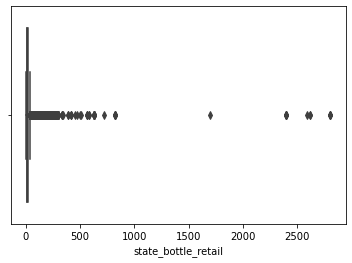

In [89]:
sns.boxplot(df['state_bottle_retail'])

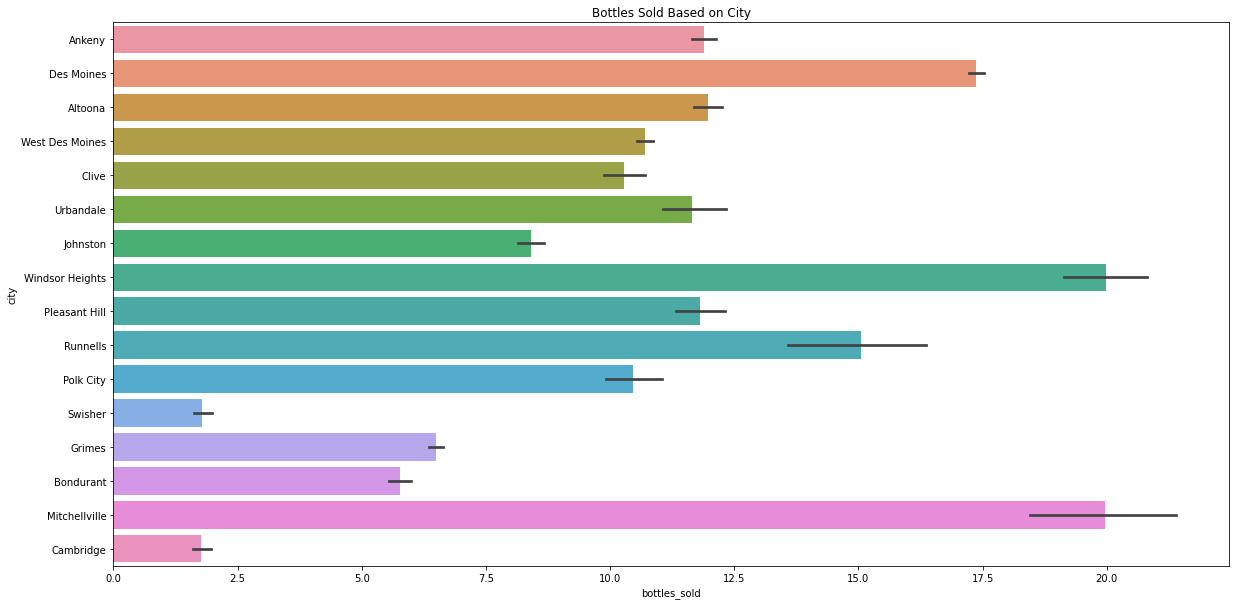

In [48]:
# This code aims to know which city that has high bottles sold
plt.figure(figsize=(20,10))
sns.barplot(y=df['city'], x=df['bottles_sold'], orient='h')
plt.title('Bottles Sold Based on City')
plt.show()

- It appears that City **Des Moines** is the highest city where the store who ordered liquor is located. The percentage reach **48%**
- In City Des Moines, most category of liquor ordered was **American Vodkas** with percentage around **14.87%**

#### Bottles Sold Mapping

In [49]:
import folium

In [51]:
df_city1['bottles_sold'].describe()

count    175380.000000
mean         12.732073
std          51.442521
min           1.000000
25%           4.000000
50%           6.000000
75%          12.000000
max       11952.000000
Name: bottles_sold, dtype: float64

In [61]:
df_Low = df_city1[df_city1['bin_bottle_sold'] == 'Low Sold']
df_High = df_city1[df_city1['bin_bottle_sold'] == 'High Sold']

In [75]:
df_High[df_High['bin_bottle_sold']=='High Sold']['bottles_sold']

5         120
22        264
244        36
532        14
560        54
         ... 
868647     48
868651     48
868685     24
868738     24
868739     24
Name: bottles_sold, Length: 20018, dtype: int64

In [88]:
df_High[df_High['bottles_sold'] == 11952.000000]

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,volume_sold_gallons,Long,Lat,bin_bottle_vol,delta_cost,revenue,date_year,date_month,date_day,bin_bottle_sold
616915,INV-14774700005,2018-10-02,2663,Hy-Vee Food Store / Urbandale,8701 Douglas,Urbandale,50322,-93.739105 41.629364,77,POLK,...,2368.03,-93.739105,41.629364,large_vol,7.8,93225.6,2018,10,Tuesday,High Sold


In [86]:
df_High['bottles_sold'].describe()

count    20018.000000
mean        57.947897
std        144.044095
min         13.000000
25%         24.000000
50%         24.000000
75%         48.000000
max      11952.000000
Name: bottles_sold, dtype: float64

In [89]:
Iowa_map = folium.Map(location = [41.629364, -93.739105], zoom_start = 10)

In [90]:
for index, row in df_Low.sample(n = 100).iterrows():
    folium.Marker(location = [row.loc['Lat'], row.loc['Long']],
                  tooltip = f"Liquor Low Sold : {row.loc['bottles_sold']}",
                  icon = folium.Icon(prefix = 'fa', color = 'red')).add_to(Iowa_map)
    
for index, row in df_High.sample(n = 100).iterrows():
    folium.Marker(location = [row.loc['Lat'], row.loc['Long']],
                  tooltip = f"Liquor High Sold : {row.loc['bottles_sold']}",
                  icon = folium.Icon(prefix = 'fa', color = 'orange')).add_to(Iowa_map)
    

In [91]:
Iowa_map

In [92]:
pd.crosstab(index=df_city1['city'], columns=df_city1['bin_bottle_sold'])

bin_bottle_sold,Low Sold,High Sold
city,,
Altoona,31600,3905
Ankeny,59172,7046
Urbandale,49072,4963
Windsor Heights,15518,4104


In [56]:
df.columns

Index(['invoice_and_item_number', 'date', 'store_number', 'store_name',
       'address', 'city', 'zip_code', 'store_location', 'county_number',
       'county', 'category', 'category_name', 'vendor_number', 'vendor_name',
       'item_number', 'item_description', 'pack', 'bottle_volume_ml',
       'state_bottle_cost', 'state_bottle_retail', 'bottles_sold',
       'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons', 'Long',
       'Lat', 'bin_bottle_vol', 'delta_cost', 'revenue', 'date_year',
       'date_month', 'date_day', 'bin_bottle_sold'],
      dtype='object')

In [57]:
df['bin_bottle_sold'].unique

<bound method Series.unique of 0          Low Sold
2          Low Sold
3          Low Sold
4          Low Sold
5         High Sold
            ...    
868898     Low Sold
868899     Low Sold
868900     Low Sold
868901     Low Sold
868902     Low Sold
Name: bin_bottle_sold, Length: 761753, dtype: category
Categories (2, object): [Low Sold < High Sold]>